# 周期分析

计算最有效的周期指标，捕捉中短期价格反转。

菲舍尔转换，带通滤波器，超级震荡指标。



In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [3]:
def read_binance_annual_ohlcv(year: int) -> pd.DataFrame:
    filepath = os.path.join("../data", f"binance_daily_ohlcv_{year}.csv")
    return pd.read_csv(filepath, index_col="timestamp", parse_dates=True)


years = [2022, 2023, 2024]
ohlcv = pd.concat((read_binance_annual_ohlcv(year) for year in years))

In [4]:
ohlcv_btc = ohlcv.query("symbol == 'BTC/USDT'").copy()
ohlcv_btc

,open,high,low,close,volume,symbol
timestamp,,,,,,
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,BTC/USDT
2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,BTC/USDT
2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,BTC/USDT
2022-01-04,46446.10,47557.54,45500.00,45832.01,35491.41360,BTC/USDT
2022-01-05,45832.01,47070.00,42500.00,43451.13,51784.11857,BTC/USDT
...,...,...,...,...,...,...
2024-04-05,68487.80,68756.67,65952.56,67820.62,37915.23073,BTC/USDT
2024-04-06,67820.63,69692.00,67447.83,68896.00,20134.28919,BTC/USDT
2024-04-07,68896.00,70326.29,68824.00,69360.39,21534.74433,BTC/USDT


In [46]:
def fisher_transform(series: pd.Series, period: int = 10) -> pd.Series:
    highest = series.rolling(period, min_periods=1).max()
    lowest = series.rolling(period, min_periods=1).min()
    values = np.zeros(len(series))
    fishers = np.zeros(len(series))

    for i in range(1, len(series)):
        values[i] = (
            0.66
            * (
                (series.iloc[i] - lowest.iloc[i]) / (highest.iloc[i] - lowest.iloc[i])
                - 0.5
            )
            + 0.67 * values[i - 1]
        )
        values[i] = max(min(values[i], 0.999), -0.999)
        fishers[i] = (
            0.5 * np.log((1 + values[i]) / (1 - values[i])) + 0.5 * fishers[i - 1]
        )

    return pd.Series(fishers, index=series.index)


def bandpass(series: pd.Series, period: int = 10, bandwidth: float = 0.5) -> pd.Series:
    const = bandwidth * 2 * np.pi / period
    beta = np.cos(2 * np.pi / period)
    gamma = 1 / np.cos(const)
    alpha1 = gamma - np.sqrt(gamma**2 - 1)
    alpha2 = (np.cos(0.25 * const) + np.sin(0.25 * const) - 1) / np.cos(0.25 * const)
    alpha3 = (np.cos(1.5 * const) + np.sin(1.5 * const) - 1) / np.cos(1.5 * const)

    hp = np.zeros(len(series))
    bp = np.zeros(len(series))
    peaks = np.zeros(len(series))
    signals = np.zeros(len(series))

    for i in range(2, len(series)):
        hp[i] = (1 + alpha2 / 2) * (series.iloc[i] - series.iloc[i - 1]) + (
            1 - alpha2
        ) * hp[i - 1]
        bp[i] = (
            0.5 * (1 - alpha1) * (hp[i] - hp[i - 2])
            + beta * (1 + alpha1) * bp[i - 1]
            - alpha1 * bp[i - 2]
        )
        peaks[i] = 0.991 * peaks[i - 1]
        if abs(bp[i]) > peaks[i]:
            peaks[i] = abs(bp[i])
        if peaks[i] != 0:
            signals[i] = bp[i] / peaks[i]

    return pd.Series(signals, index=series.index)


def _center_gravity(series: pd.Series) -> float:
    nm = 0
    dm = 0
    reversed_series = series[::-1]
    for i, value in enumerate(reversed_series):
        nm += (i + 1) * value
        dm += value
    try:
        return -nm / dm + (len(series) + 1) / 2
    except ZeroDivisionError:
        return 0


def stoch_center_gravity_osc(series: pd.Series, period: int = 10) -> pd.Series:
    center_gravity = series.rolling(period, min_periods=1).apply(_center_gravity)
    max_cg = center_gravity.rolling(period, min_periods=1).max()
    min_cg = center_gravity.rolling(period, min_periods=1).min()
    cg_range = (max_cg - min_cg).replace({0: np.nan})
    stoch = ((center_gravity - min_cg) / cg_range).fillna(0)
    smooth_stoch = (
        4 * stoch + 3 * stoch.shift(1) + 2 * stoch.shift(2) + stoch.shift(3)
    ) / 10
    return 2 * (smooth_stoch - 0.5)

In [47]:
# ohlcv_btc["ft"] = fisher_transform(ohlcv_btc["close"])
# ohlcv_btc["bp"] = bandpass(ohlcv_btc["close"], 10, 0.5)
ohlcv_btc["osc"] = stoch_center_gravity_osc(ohlcv_btc["close"], 10)
ohlcv_btc

,open,high,low,close,volume,symbol,bp,osc
timestamp,,,,,,,,
2024-01-01,42283.58,44184.10,42180.77,44179.55,27174.29903,BTC/USDT,0.265984,NaN
2024-01-02,44179.55,45879.63,44148.34,44946.91,65146.40661,BTC/USDT,0.699059,NaN
2024-01-03,44946.91,45500.00,40750.00,42845.23,81194.55173,BTC/USDT,0.600916,NaN
2024-01-04,42845.23,44729.58,42613.77,44151.10,48038.06334,BTC/USDT,0.215337,-0.383465
2024-01-05,44151.10,44357.46,42450.00,44145.11,48075.25327,BTC/USDT,-0.010130,-0.294357
...,...,...,...,...,...,...,...,...
2024-04-05,68487.80,68756.67,65952.56,67820.62,37915.23073,BTC/USDT,0.025173,-0.950743
2024-04-06,67820.63,69692.00,67447.83,68896.00,20134.28919,BTC/USDT,0.348329,-0.967301
2024-04-07,68896.00,70326.29,68824.00,69360.39,21534.74433,BTC/USDT,0.547148,-0.826705


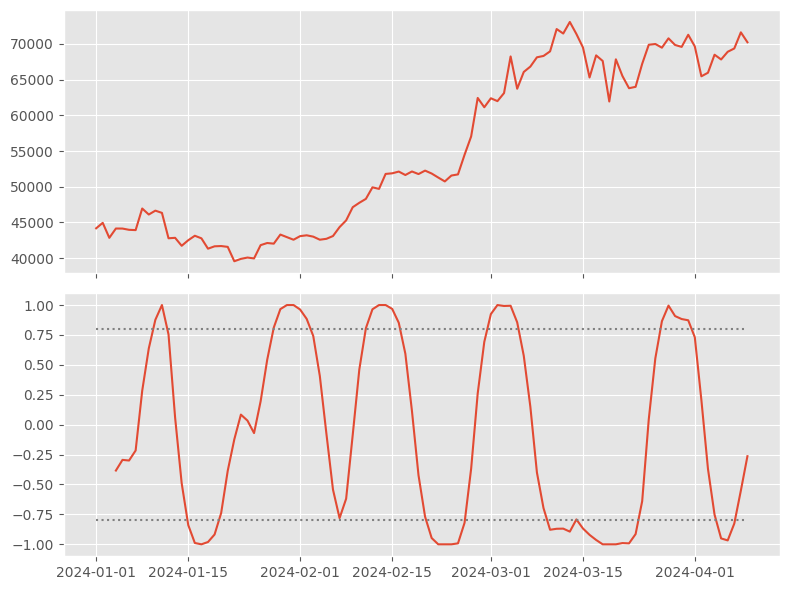

In [48]:
start_date = "2024-01-01"
end_date = "2024-04-30"
oscillator_column = "osc"

ohlcv_btc = ohlcv_btc.loc[start_date:end_date].copy()

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax0.plot(ohlcv_btc["close"])
ax1.plot(ohlcv_btc[oscillator_column])
ax1.hlines(0.8, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")
ax1.hlines(-0.8, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")
# ax1.hlines(3, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")
# ax1.hlines(-3, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")

# ax0.set_title("Fisher transform of BTC/USDT close price")

plt.tight_layout()